In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = 'nearest'

The plan is to re-create figure 3 of [Saxe, McClelland and Ganguly](https://arxiv.org/pdf/1312.6120v3.pdf), but have
a go with a ReLU rather than a tanh as that is more interesting practically.

The first thing to do is to try to plot the analytical curve:
$$
    u_f(t) = \frac{se^{\frac{2st}{\tau}}}{e^{\frac{2st}{\tau}} - 1 + \frac{s}{u_0}}
$$ for small $u_0$. From the paper, we'll try $t$ from $0$ to around $1200$. To get $s$ we need some data, it is a
singular value of the data correlation matrix. For now we'll just plug in a couple of numbers and see if it looks about right.

In [2]:
def curve(t, s, tau, u_nought):
    """only one s at a time"""
    exps = np.exp((2*s*t) / tau)
    return (s * exps) / (exps - 1 + s/u_nought)

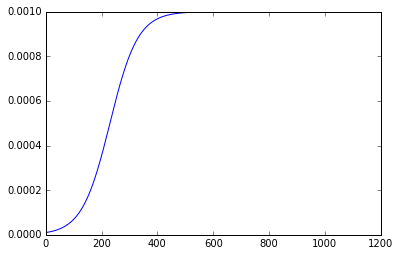

In [3]:
time = np.arange(1200.0)
s = 0.001
tau = 0.1
u_nought = 0.00001

y = curve(time, s, tau, u_nought)

plt.plot(time, y)

Could be worse, let's go ahead and make some real data. The data used for this figure was apparently generated according to a procedure described in a [different paper](http://www-psych.stanford.edu/~jlm/papers/SaxeMcCGanguli13CogSciProc.pdf) by the same authors.

The data is described as follows:
>The training set consists of 32 orthogonal input patterns, each
>associated with a 1000-dimensional feature vector generated by a hierarchical diffusion process described
>in [16] with a five level binary tree and flip probability of 0.1 

The hierarchical diffusion process is indeed described in the other paper, and it is slightly odd. At first, however,
we note that all we know about the training data is that the outputs have $1000$ dimensions and there are 32 patterns.
That there are 32 patterns necessarily corresponds to the binary tree process used to generate the data, but we have no idea at all how big the input patterns are.

The procedure is as follows:
- generate a binary tree with one leaf node per output pattern
- for each feature do:
    - set the root node to 1 or -1 with probability 0.5
    - while not at the lowest level
        - propagate the value of each node in the higher level to its children
        - with probability $\epsilon$ flip the value
        
        
        
This is desperately unpleasant. How about we just use MNIST instead.
Or even easier, SKLearn's digits.

In [4]:
import sklearn.datasets

data_dict = sklearn.datasets.load_digits()
print(data_dict['DESCR'])

Optical Recognition of Handwritten Digits Data Set

Notes
-----
Data Set Characteristics:
    :Number of Instances: 5620
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
http://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each block. This generates
an input matrix of 8x8 where each element is a

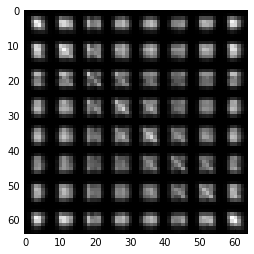

In [5]:
# we are going to need the svd of the full input-output covariance
# but the paper assumes that the input-input covariance matrix is identity
# so let's try and get close to that
# firstly, what does it actually look like?
images = data_dict['data']
in_in_cov = np.dot(images.T, images)

plt.imshow(in_in_cov)

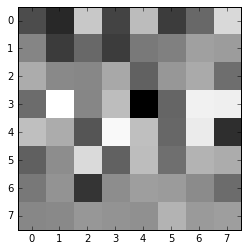

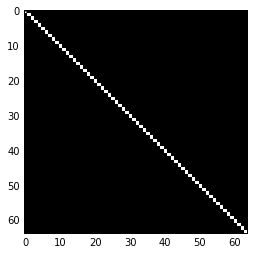

In [6]:
# kind of diagonal, but we can do better
from sklearn.decomposition import PCA
pca = PCA(n_components=64, whiten=True)
whitened = pca.fit_transform(images)

plt.imshow(whitened[10,...].reshape((8, 8)))
plt.show()

in_in_cov = np.dot(whitened.T, whitened)
plt.imshow(in_in_cov)
plt.show()

(10, 64)


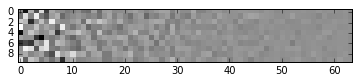

In [7]:
# cool let's get the input-output correlation matrix
targets = data_dict['target']
# convert to one-hot
labels = np.zeros((targets.shape[0], 10))
labels[np.arange(len(labels)), targets] = 1

io_corr = np.dot(labels.T, whitened)
print(io_corr.shape)
plt.imshow(io_corr)

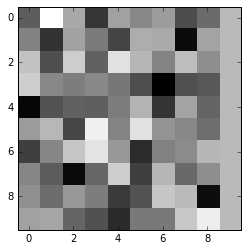

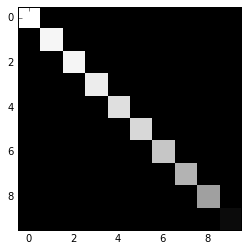

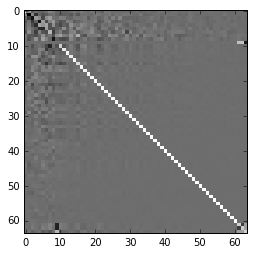

In [8]:
# we also need its SVD
u, s, vT = np.linalg.svd(io_corr, full_matrices=True)
plt.imshow(u)
plt.show()
plt.imshow(np.diag(s))
plt.show()
plt.imshow(vT)
plt.show()

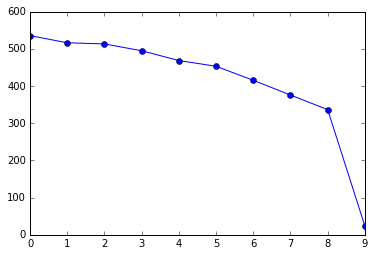

In [9]:
# let's have a quick look at the scale of those singular values
plt.plot(s, marker='o')

In [83]:
import tensorflow as tf

def get_net(input_var, nonlinearity=None):
    """Gets the output of a net. The net has one hidden layer,
    a linear output layer (maybe) and 32 hidden units."""
    input_size = input_var.get_shape()[1].value
    input_weights = tf.get_variable('W21', shape=[input_size, 32])
    output_weights = tf.get_variable('W32', shape=[32, 10])
    print(output_weights.get_shape())
    hidden_acts = tf.matmul(input_var, input_weights)
    if nonlinearity:
        hidden_acts = nonlinearity(hidden_acts)
        
    output = tf.matmul(hidden_acts, output_weights)
    
    return output

In [84]:
def mode_strengths(inputs, outputs, u, vT):
    """Returns the input-output correlation matrix,
    with the effects of U and V removed (so how strongly the correlation represents
    the connections between the true input and output modes).
    Assume they're all tensorflow variables.
    To make the plots in Saxe, we need the diagonals of what this returns, but it seems
    like it might be fun to actually have a look at the whole thing.
    """
    correlation = tf.matmul(outputs, inputs, transpose_a=True, b_is_sparse=True)
    
    return tf.matmul(tf.matmul(u, correlation, transpose_a=True), vT, transpose_b=True)

In [102]:
def orthonormal_init():
    def _on_init(shape, dtype=tf.float32):
        if len(shape) != 2:
            raise ValueError('nope')
        np.random.seed(1234)
        mat = np.random.normal(size=shape)
        q, _ = np.linalg.qr(mat)
        return q  # need to be more carfeul about the shapes here
    return _on_init

def glorot_uniform_init():
    def _gu_init(shape, dtype=tf.float32):
        if len(shape) != 2:
            raise ValueError('need shape of length 2')
        scale = np.sqrt(6) / np.sqrt(shape[0] + shape[1])
        np.random.seed(1234)
        return np.random.uniform(-scale, scale, shape)
    return _gu_init

In [122]:
tf.reset_default_graph()

# we are going offline
input_pl = tf.placeholder(tf.float32, name='inputs', shape=[whitened.shape[0], 64])
label_pl = tf.placeholder(tf.float32, name='labels', shape=[labels.shape[0], 10])

u_var = tf.constant(u.astype(np.float32))
vT_var = tf.constant(vT.astype(np.float32))

nets = {
    'linear-ortho': {
        'nonlinearity': None,
        'init': orthonormal_init()
    },
    'relu-ortho': {
        'nonlinearity': tf.nn.relu,
        'init': orthonormal_init()
    },
    'tanh-ortho': {
        'nonlinearity': tf.nn.tanh,
        'init': orthonormal_init()
    },
    'sigmoid-ortho': {
        'nonlinearity': tf.nn.sigmoid,
        'init': orthonormal_init()
    },
    'linear-glorot': {
        'nonlinearity': None,
        'init': glorot_uniform_init()
    },
    'relu-glorot': {
        'nonlinearity': tf.nn.relu,
        'init': glorot_uniform_init()
    },
    'tanh-glorot': {
        'nonlinearity': tf.nn.tanh,
        'init': glorot_uniform_init()
    },
    'sigmoid-glorot': {
        'nonlinearity': tf.nn.sigmoid,
        'init': glorot_uniform_init()
    }
}

for name in nets:
    with tf.variable_scope(name, initializer=nets[name]['init']):
        outs = get_net(input_pl, nets[name]['nonlinearity'])
        nets[name]['outs'] = outs
        
        strs = mode_strengths(input_pl, outs, u_var, vT_var)
        nets[name]['strengths'] = strs
        
        loss = tf.reduce_mean(tf.squared_difference(outs, label_pl))
        # loss = tf.nn.softmax_cross_entropy_with_logits(outs, label_pl)
        # loss = tf.reduce_mean(loss)
        nets[name]['loss'] = loss
        
        opt = tf.train.GradientDescentOptimizer(0.1)
        train = opt.minimize(loss)
        nets[name]['train'] = train

(32, 10)
(32, 10)
(32, 10)
(32, 10)
(32, 10)
(32, 10)
(32, 10)
(32, 10)


In [123]:
sess = tf.Session()

sess.run(tf.initialize_all_variables())

strengths = {name: [] for name in nets}
losses = {name: [] for name in nets}
with sess.as_default():
    
    for epoch in range(5000):
        if epoch % 100 == 0:
            print('                                                                         \r({})'.format(epoch), end='')
        for name, net in nets.items():
            loss, mode_strength, _ = sess.run([net['loss'], net['strengths'], net['train']],
                                              feed_dict={input_pl: whitened,
                                                         label_pl: labels})
            if epoch % 100 == 0:
                print('{} loss: {}  '.format(name, loss), end='', flush=True)
            losses[name].append(loss)
            strengths[name].append(mode_strength)

(4900)linear-ortho loss: 0.040758054703474045  relu-ortho loss: 0.01536268088966608  linear-glorot loss: 0.040751565247774124  relu-glorot loss: 0.016484206542372704  tanh-glorot loss: 0.030463431030511856  sigmoid-glorot loss: 0.030541224405169487  sigmoid-ortho loss: 0.030560649931430817  tanh-ortho loss: 0.031217196956276894  

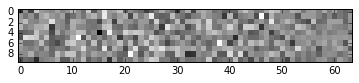

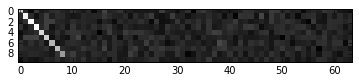

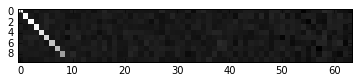

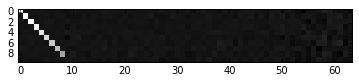

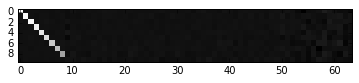

In [128]:
for mat in strengths['sigmoid-ortho'][::1000]:
    plt.imshow(mat)
    plt.show()

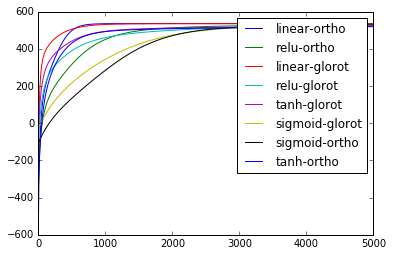

In [129]:
for name in nets:
    plt.plot([mat[0, 0] for mat in strengths[name]], label=name)
plt.legend()

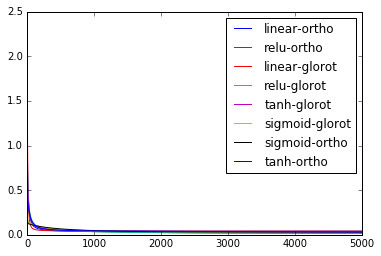

In [130]:
for name in nets:
    plt.plot(losses[name], label=name)
plt.legend()

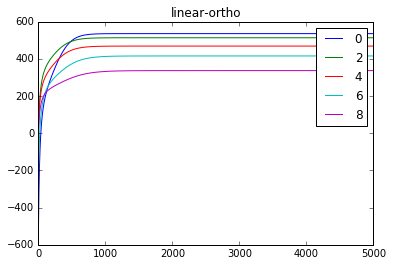

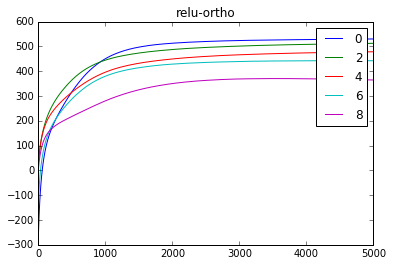

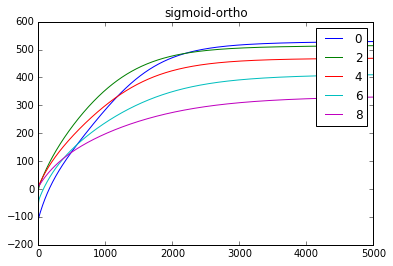

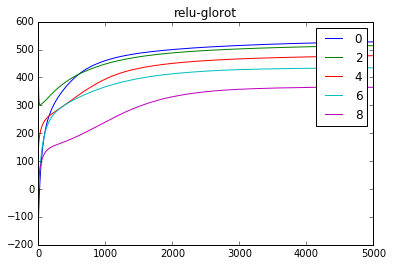

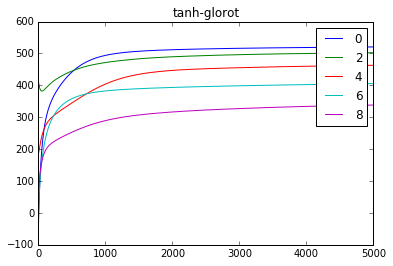

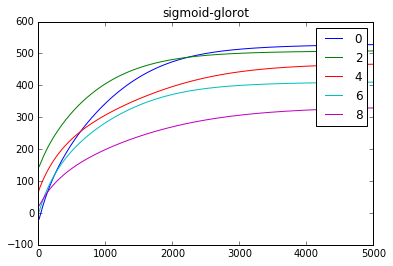

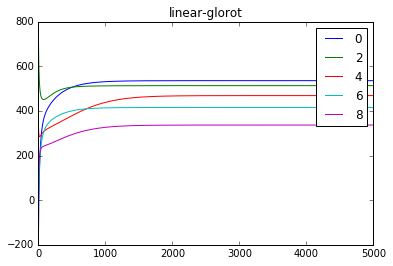

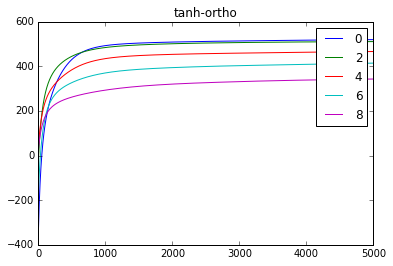

In [131]:
colours = {name: color for name, color in zip(list([net for net in nets]),
                                              ['blue', 'green', 'red', 'yellow', 'orange'])}

for name in strengths:
    plt.title(name)
    for i in range(0, 10, 2):
        plt.plot([mat[i, i] for mat in strengths[name]], label=i)
    plt.legend()
    plt.show()